In [1]:
import sys
import os
import numpy as np
import keras
import tensorflow as tf
import keras.backend as K
import matplotlib
import matplotlib.pyplot as plt
import subprocess
import time
from tqdm import tqdm

Using TensorFlow backend.


In [168]:
sys.path.append(os.path.abspath('../'))
sys.path.append(os.path.abspath('../tests'))

from keras2c.keras2c_main import k2c

def build_and_run(name, return_output=False):
    
    cwd = os.getcwd()
    os.chdir(os.path.abspath('./include/'))
    lib_code = subprocess.run(['make'],capture_output=True, text=True)
    os.chdir(os.path.abspath(cwd))
    if lib_code.returncode != 0:
        print('lib failed')
        return lib_code if return_output else 'lib build failed'
    optflags = "-O3 -march=native -fwhole-program -fopt-info-vec -fopt-info-vec-missed"
    if os.environ.get('CI'):
        ccflags = '-g -Og -std=c99 --coverage -I./include/'
    else:
        ccflags = optflags +  " -std=c99 -I./include/"

    cc = 'gcc ' + ccflags + ' -o ' + name + ' ' + name + '.c ' + \
        name + '_test_suite.c -L./include/ -l:libkeras2c.a -lm'
    build_code = subprocess.run(cc.split(),capture_output=True, text=True)
    if build_code.returncode != 0:
        print('build failed')
        return build_code if return_output else 'build failed'
    proc_output = subprocess.run(['./' + name],capture_output=True, text=True)
    rcode = proc_output.returncode
    if rcode == 0:
        if not os.environ.get('CI'):
            subprocess.run('rm ' + name + '*', shell=True)
            return prod_output if return_output else rcode
    else:
        print('test failed')
        return rcode

In [173]:
#os.chdir('../')
os.getcwd()

'/home/fouriest/SCHOOL/Princeton/PPPL/keras2c'

In [150]:
num_cores = 1
config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,
                        inter_op_parallelism_threads=num_cores, 
                        allow_soft_placement=True,
                        device_count = {'CPU' : 1,
                                        'GPU' : 0})
session = tf.Session(config=config)
K.set_session(session)

In [329]:
%matplotlib inline

matplotlib_colors = [(0.1215, 0.4667, 0.7058), # blue
                     (1.0000, 0.4980, 0.0549), # orange
                     (0.1725, 0.6275, 0.1725), # green
                     (0.8392, 0.1529, 0.1568), # red
                     (0.5804, 0.4039, 0.7412), # violet
                     (0.4980, 0.4980, 0.4980), # grey
                     (0.0902, 0.7450, 0.8117)] # cyan

matlab_colors=[(0.0000, 0.4470, 0.7410), # blue
               (0.8500, 0.3250, 0.0980), # reddish orange
               (0.9290, 0.6940, 0.1250), # yellow
               (0.4940, 0.1840, 0.5560), # purple
               (0.4660, 0.6740, 0.1880), # light green
               (0.3010, 0.7450, 0.9330), # cyan
               (0.6350, 0.0780, 0.1840)] # dark red

colorblind_colors = [(0.0000, 0.4500, 0.7000), # blue
                     (0.8359, 0.3682, 0.0000), # vermillion
                     (0.0000, 0.6000, 0.5000), # bluish green
                     (0.9500, 0.9000, 0.2500), # yellow
                     (0.3500, 0.7000, 0.9000), # sky blue
                     (0.8000, 0.6000, 0.7000), # reddish purple
                     (0.9000, 0.6000, 0.0000)] # orange

dashes = [(1.0, 0.0, 0.0, 0.0, 0.0, 0.0), # solid
          (3.7, 1.6, 0.0, 0.0, 0.0, 0.0), # dashed
          (1.0, 1.6, 0.0, 0.0, 0.0, 0.0), # dotted
          (6.4, 1.6, 1.0, 1.6, 0.0, 0.0), # dot dash
          (3.0, 1.6, 1.0, 1.6, 1.0, 1.6), # dot dot dash
          (6.0, 4.0, 0.0, 0.0, 0.0, 0.0), # long dash
          (1.0, 1.6, 3.0, 1.6, 3.0, 1.6)] # dash dash dot

from matplotlib import rcParams, cycler
matplotlib.rcdefaults()
rcParams['font.family'] = 'DejaVu Serif'
rcParams['font.size'] = 12
rcParams['figure.facecolor'] = (1,1,1,1)
rcParams['figure.figsize'] = (16,8)
rcParams['figure.dpi'] = 96
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.labelsize'] =  'large'
rcParams['axes.titlesize'] = 'x-large'
rcParams['lines.linewidth'] = 2.5
rcParams['lines.solid_capstyle'] = 'round'
rcParams['lines.dash_capstyle'] = 'round'
rcParams['lines.dash_joinstyle'] = 'round'
rcParams['xtick.labelsize'] = 'large'
rcParams['ytick.labelsize'] = 'large'

color_cycle = cycler(color=colorblind_colors)
dash_cycle = cycler(dashes=dashes)
rcParams['axes.prop_cycle'] =  dash_cycle + color_cycle

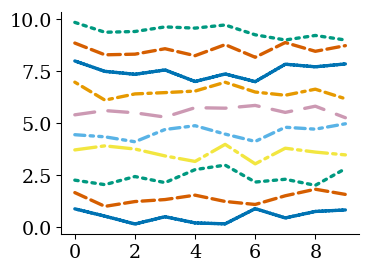

In [336]:
fig = plt.figure(figsize=(4,3))
for i in range(10):
    plt.plot(i+np.random.random(10))

In [152]:
def time_model(model,num_tests):
    k2c(model,'foo',num_tests=num_tests,malloc=False,verbose=False)
    out = build_and_run('foo',True)
    ctime = float(out.stdout.split('\n')[0].split(' ')[-3])
    inp = np.random.random((num_tests,*model.input_shape[1:]))
    nparams = model.count_params()
    t0 = time.time_ns()
    for i in range(num_tests):
        foo = model.predict(inp[i,np.newaxis,:])
    t1 = time.time_ns()
    pytime = (t1-t0)/10**9/num_tests
    return nparams, ctime, pytime

In [153]:
time_data = {}

In [171]:
k2c(model,'foo',num_tests=num_tests,malloc=False,verbose=False)

out = build_and_run('foo',True)

build failed


In [154]:
"""Dense Model"""
size = []
ctimes = []
pytimes = []
num_tests = 50
dims = [8,16,32,64,128,256,512,1024]
indims = dims[:-1]
outdims = dims[1:]
for indim,dim in tqdm(zip(indims,outdims)):
    inshp=(50,indim)
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(dim,input_shape=inshp))
    model.build()
    nparams, ctime, pytime = time_model(model,num_tests)
    size.append(nparams)
    ctimes.append(ctime)
    pytimes.append(pytime)

time_data['Dense'] = {'size': size,
                     'ctimes':ctimes,
                     'pytimes':pytimes}
plt.loglog(size,ctimes,'-o',size,pytimes,'-v')
plt.ylabel('Time (s)')
plt.xlabel('Model size (number of parameters)')
plt.legend(['keras2c','keras python'])



0it [00:00, ?it/s]

AttributeError: 'NoneType' object has no attribute 'split'


0it [00:00, ?it/s]
1it [00:02,  2.22s/it]
2it [00:04,  2.32s/it]
3it [00:07,  2.58s/it]
4it [00:12,  3.23s/it]
5it [00:21,  4.77s/it]
6it [00:37,  8.20s/it]
7it [01:13, 16.61s/it]

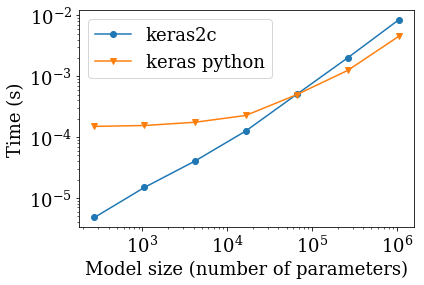

In [16]:
"""Conv1D Model"""
size = []
ctimes = []
pytimes = []
num_tests = 50
dims = [8,16,32,64,128,256,512,1024]
indims = dims[:-1]
outdims = dims[1:]
for indim,dim in tqdm(zip(indims,outdims)):
    inshp=(50,indim)
    model = keras.models.Sequential()
    model.add(keras.layers.Conv1D(dim,kernel_size=2,input_shape=inshp))
    model.build()
    nparams, ctime, pytime = time_model(model,num_tests)
    size.append(nparams)
    ctimes.append(ctime)
    pytimes.append(pytime)

time_data['Conv1D'] = {'size': size,
                     'ctimes':ctimes,
                     'pytimes':pytimes}
plt.loglog(size,ctimes,'-o',size,pytimes,'-v')
plt.ylabel('Time (s)')
plt.xlabel('Model size (number of parameters)')
plt.legend(['keras2c','keras python'])


0it [00:00, ?it/s]
1it [00:34, 34.98s/it]
2it [01:44, 45.46s/it]
3it [04:02, 73.23s/it]
4it [08:30, 131.57s/it]

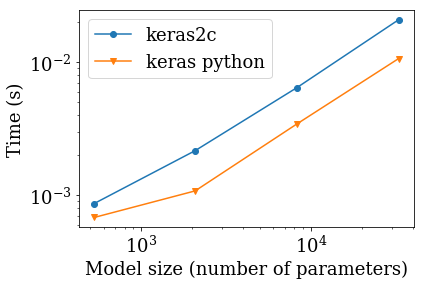

In [17]:
"""Conv2D Model"""
size = []
ctimes = []
pytimes = []
num_tests = 50
dims = [8,16,32,64,128]
indims = dims[:-1]
outdims = dims[1:]
for indim,dim in tqdm(zip(indims,outdims)):
    inshp=(64,64,indim)
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(dim,kernel_size=2,input_shape=inshp))
    model.build()
    nparams, ctime, pytime = time_model(model,num_tests)
    size.append(nparams)
    ctimes.append(ctime)
    pytimes.append(pytime)

time_data['Conv2D'] = {'size': size,
                     'ctimes':ctimes,
                     'pytimes':pytimes}
plt.loglog(size,ctimes,'-o',size,pytimes,'-v')
plt.ylabel('Time (s)')
plt.xlabel('Model size (number of parameters)')
plt.legend(['keras2c','keras python'])


0it [00:00, ?it/s]
1it [00:02,  2.35s/it]
2it [00:04,  2.40s/it]
3it [00:07,  2.60s/it]
4it [00:12,  3.13s/it]
5it [00:20,  4.61s/it]
6it [00:43, 10.05s/it]

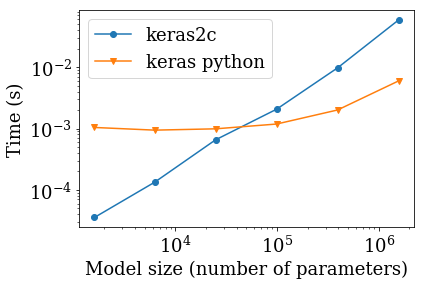

In [18]:
"""LSTM Model"""
size = []
ctimes = []
pytimes = []
num_tests = 50
dims = [8,16,32,64,128,256,512]
indims = dims[:-1]
outdims = dims[1:]
for indim,dim in tqdm(zip(indims,outdims)):
    inshp=(20,indim)
    model = keras.models.Sequential()
    model.add(keras.layers.LSTM(dim,return_sequences=True,input_shape=inshp))
    model.build()
    nparams, ctime, pytime = time_model(model,num_tests)
    size.append(nparams)
    ctimes.append(ctime)
    pytimes.append(pytime)

time_data['LSTM'] = {'size': size,
                     'ctimes':ctimes,
                     'pytimes':pytimes}
plt.loglog(size,ctimes,'-o',size,pytimes,'-v')
plt.ylabel('Time (s)')
plt.xlabel('Model size (number of parameters)')
plt.legend(['keras2c','keras python'])

In [56]:
%timeit model.predict(inp[1,np.newaxis,:])

1.23 ms ± 14.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


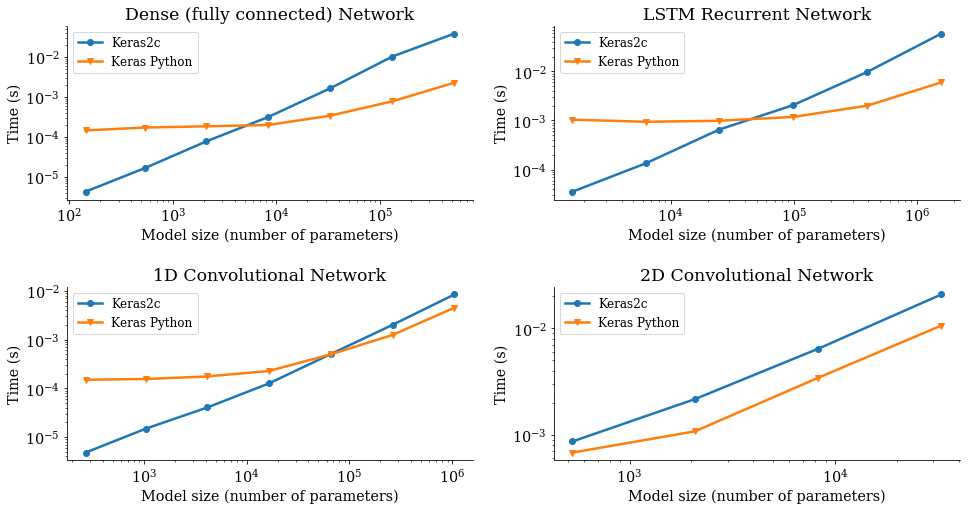

In [95]:
%matplotlib inline
font={'family': 'DejaVu Serif',
      'size': 12}
plt.rc('font', **font)
matplotlib.rcParams['figure.facecolor'] = (1,1,1,1)

fig, ax = plt.subplots(2,2,figsize=(16,8))
ax[0,0].loglog(time_data['Dense']['size'],time_data['Dense']['ctimes'],marker='o',label='Keras2c')
ax[0,0].loglog(time_data['Dense']['size'],time_data['Dense']['pytimes'],marker='v',label='Keras Python')
ax[0,0].set_ylabel('Time (s)')
ax[0,0].set_xlabel('Model size (number of parameters)')
ax[0,0].set_title('Dense (fully connected) Network')
ax[0,0].legend()

ax[0,1].loglog(time_data['LSTM']['size'],time_data['LSTM']['ctimes'],marker='o',label='Keras2c')
ax[0,1].loglog(time_data['LSTM']['size'],time_data['LSTM']['pytimes'],marker='v',label='Keras Python')
ax[0,1].set_ylabel('Time (s)')
ax[0,1].set_xlabel('Model size (number of parameters)')
ax[0,1].set_title('LSTM Recurrent Network')
ax[0,1].legend()

ax[1,0].loglog(time_data['Conv1D']['size'],time_data['Conv1D']['ctimes'],marker='o',label='Keras2c')
ax[1,0].loglog(time_data['Conv1D']['size'],time_data['Conv1D']['pytimes'],marker='v',label='Keras Python')
ax[1,0].set_ylabel('Time (s)')
ax[1,0].set_xlabel('Model size (number of parameters)')
ax[1,0].set_title('1D Convolutional Network')
ax[1,0].legend()

ax[1,1].loglog(time_data['Conv2D']['size'],time_data['Conv2D']['ctimes'],marker='o',label='Keras2c')
ax[1,1].loglog(time_data['Conv2D']['size'],time_data['Conv2D']['pytimes'],marker='v',label='Keras Python')
ax[1,1].set_ylabel('Time (s)')
ax[1,1].set_xlabel('Model size (number of parameters)')
ax[1,1].set_title('2D Convolutional Network')
ax[1,1].legend()

plt.subplots_adjust(hspace=0.5)
# plt.savefig('benchmarking.png',bbox_inches='tight')

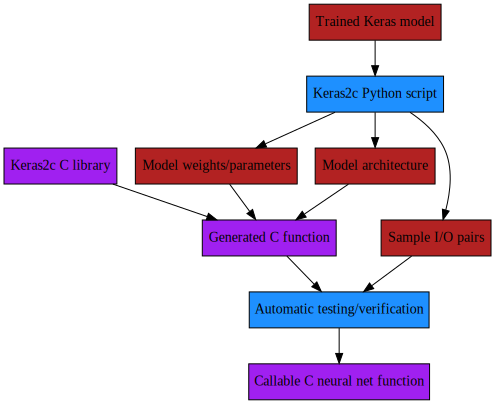

In [80]:
import pydot
from IPython.display import SVG

graph = pydot.Dot(graph_type='digraph')

nodes = {'Keras2c C library': pydot.Node("Keras2c C library", shape='box', style="filled", fillcolor="purple"),
        'Trained Keras model':pydot.Node("Trained Keras model", shape='box', style="filled", fillcolor="firebrick"),
        'Keras2c Python script':pydot.Node("Keras2c Python script", shape='box', style="filled", fillcolor="dodgerblue"),
        'Model weights/parameters':pydot.Node("Model weights/parameters", shape='box', style="filled", fillcolor="firebrick"),
        'Model architecture':pydot.Node("Model architecture", shape='box', style="filled", fillcolor="firebrick"),
        'Sample I/O pairs':pydot.Node("Sample I/O pairs", shape='box', style="filled", fillcolor="firebrick"),
        'Generated C function':pydot.Node("Generated C function", shape='box', style="filled", fillcolor="purple"),
        'Automatic testing/verification':pydot.Node("Automatic testing/verification", shape='box', style="filled", fillcolor="dodgerblue"),
        'Callable C neural net function':pydot.Node("Callable C neural net function", shape='box', style="filled", fillcolor="purple")}         


for k,v in nodes.items():
    graph.add_node(v)

graph.add_edge(pydot.Edge(nodes['Trained Keras model'], nodes['Keras2c Python script']))
graph.add_edge(pydot.Edge(nodes['Keras2c Python script'], nodes['Model weights/parameters']))

graph.add_edge(pydot.Edge(nodes['Keras2c Python script'], nodes['Model architecture']))
graph.add_edge(pydot.Edge(nodes['Keras2c Python script'], nodes['Sample I/O pairs']))
graph.add_edge(pydot.Edge(nodes['Keras2c C library'], nodes['Generated C function']))
graph.add_edge(pydot.Edge(nodes['Model weights/parameters'], nodes['Generated C function']))
graph.add_edge(pydot.Edge(nodes['Model architecture'], nodes['Generated C function']))
graph.add_edge(pydot.Edge(nodes['Generated C function'],nodes['Automatic testing/verification']))
graph.add_edge(pydot.Edge(nodes['Sample I/O pairs'],nodes['Automatic testing/verification']))
graph.add_edge(pydot.Edge(nodes['Automatic testing/verification'],nodes['Callable C neural net function']))




SVG(graph.create(prog='dot', format='svg'))
# graph.write_png('flow_graph.png')